In [1]:
import tensorflow as tf
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from tensorflow.keras import layers, models
import pickle

In [2]:
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"GPU detected: {device_name}")
else:
    print("GPU not found. Go to Runtime > Change runtime type > GPU")

GPU detected: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip -q "/content/drive/MyDrive/MLHD_Project/Data/processed_dataset.zip" -d "/content"

replace /content/processed_dataset/test/backward/03401e93_nohash_0.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
PROJECT_DIR = "/content/drive/MyDrive/MLHD_Project"
PROCESSED_DATA_DIR = "/content/processed_dataset"

with open(PROJECT_DIR + "/Data/class_weights.pkl", "rb") as f:
    class_weights = pickle.load(f)

with open(PROJECT_DIR + "/Data/label_to_index.pkl", "rb") as f:
    label_to_index = pickle.load(f)

with open(PROJECT_DIR + "/Data/index_to_label.pkl", "rb") as f:
    index_to_label = pickle.load(f)

In [6]:
def load_dataset(split_path, label_to_index, input_shape=(40, 101), shuffle=True):
    data = []
    labels = []

    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            if not fname.endswith(".npy"):
                continue

            file_path = os.path.join(label_path, fname)
            spectrogram = np.load(file_path).astype(np.float32)

            # Ensure shape matches
            if spectrogram.shape != input_shape:
                print(f"Skipping {file_path} due to shape mismatch: {spectrogram.shape}")
                continue

            data.append(spectrogram)
            labels.append(label_to_index[label])

    data = np.array(data)[..., np.newaxis]  # Add channel dim
    labels = np.array(labels)

    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(data))

    return dataset

In [7]:
train_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "train"), label_to_index)
val_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "val"), label_to_index, shuffle=False)
test_ds = load_dataset(os.path.join(PROCESSED_DATA_DIR, "test"), label_to_index, shuffle=False)

BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
class ResidualCNN:
    def __init__(self, input_shape=(40, 101, 1), num_classes=35):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self._build_model()

    def _res_block(self, x, filters, stride=1):
        shortcut = x

        # First convolutional layer
        x = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Second convolutional layer
        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Shortcut connection
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.ReLU()(x)
        return x

    def _build_model(self):
        inputs = layers.Input(shape=self.input_shape)

        x = layers.Conv2D(32, kernel_size=3, strides=1, padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        # Residual blocks
        x = self._res_block(x, 32)
        x = self._res_block(x, 64, stride=2)
        x = self._res_block(x, 128, stride=2)

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.3)(x)
        outputs = layers.Dense(self.num_classes, activation='softmax')(x)

        model = models.Model(inputs, outputs)
        return model

    def compile(self, optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def get_model(self):
        return self.model

In [ ]:
residual_cnn = ResidualCNN(input_shape=(40, 101, 1), num_classes=len(label_to_index))
model = residual_cnn.get_model()
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.0581 - loss: 3.5752 - val_accuracy: 0.1411 - val_loss: 3.2536
Epoch 2/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.1056 - loss: 3.3370 - val_accuracy: 0.2287 - val_loss: 2.9059
Epoch 3/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.1454 - loss: 3.1600 - val_accuracy: 0.2987 - val_loss: 2.6079
Epoch 4/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.1801 - loss: 2.9623 - val_accuracy: 0.3390 - val_loss: 2.4279
Epoch 5/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.2239 - loss: 2.7857 - val_accuracy: 0.3996 - val_loss: 2.2204
Epoch 6/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.2506 - loss: 2.6519 - val_accuracy: 0.4349 - val_loss: 2.0406
Epoch 7/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - accuracy: 0.2797 - loss: 2.5054 - val_accuracy: 0.5022 - val_loss: 1.8553
Epoch 8/20
2652/2652 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.3091 -

In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7488 - loss: 0.9375

Test accuracy: 0.7812
Test loss: 0.8142


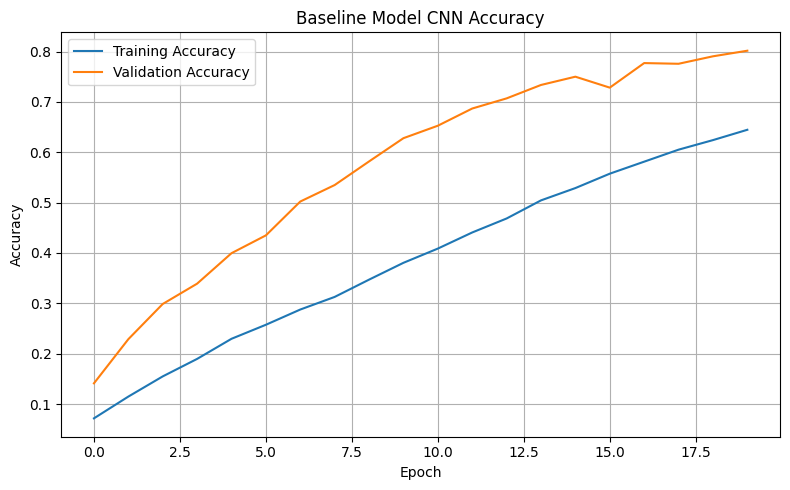

In [ ]:
history_dict = history.history
plt.figure(figsize=(8, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Residual CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MLHD_Project/residual_cnn_accuracy.png")
plt.show()

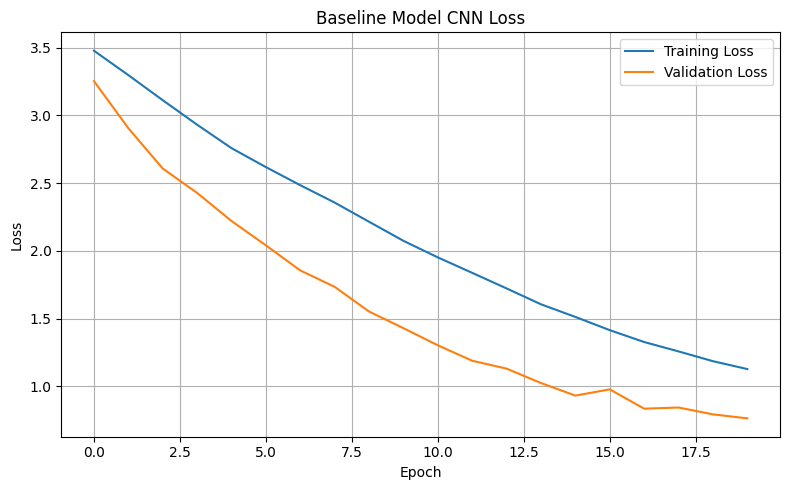

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Residual CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MLHD_Project/residual_cnn_loss.png")
plt.show()

In [14]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation accuracy: {val_acc:.4f}")
print(f"Validation loss: {val_loss:.4f}")

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7751 - loss: 0.8548

Validation accuracy: 0.8017
Validation loss: 0.7631


In [ ]:
model.save_weights("/content/drive/MyDrive/MLHD_Project/residual_cnn.weights.h5")

In [ ]:
model.save("/content/drive/MyDrive/MLHD_Project/residual_cnn_model.keras")